### Preliminaries - installing and loading packages

1. install pytorch

2. see this link: https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html for installing pytorch geometric, which you will need for GNNs

for further reading on basic experiments with GNNs see these blog posts
#### https://mlabonne.github.io/blog/intrognn/
#### https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8


### Imports for the project

In [1]:
# PyTorch for networks
import torch
# PyTorch geometric for GNNs
import torch_geometric
# Dataset creation objects
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
# model layers we will use
from torch_geometric.nn import GraphConv, BatchNorm
# Numpy for matrices
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

/home/fagg/miniconda3/envs/tf_bleeding5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Building the dataset for training

In [2]:
# Dataset classes in torch inherit from the Dataset object, for this we will be using an in-memory dataset
class MesonetGraphDataset(InMemoryDataset):
    # root parameter is important, and from the root path './data/' must contain the numpy files and have enough space to store the dataset object
    def __init__(self, root, transform=None, pre_transform=None):
        super(MesonetGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
    # ignore
    @property
    def raw_file_names(self):
        return []
    # after the first initialization this file will be loaded
    @property
    def processed_file_names(self):
        return ['../data/MesonetGraphDataset.dataset']
    # ignore - could put the data download here if you wanted to make the dataset more portable
    def download(self):
        pass
    # this happens when the dataset object and file are first created, but only once
    def process(self):
        # load the data from the numpy files
        loaded = np.load('./data/nanless_station_times.npy')
        edges = np.load('./data/distance_weights.npy')
        # convert the dataset into samples, nodes, features 
        dataset = np.transpose(loaded, [1, 0, 2])
        # get the edges
        edges_no_weights = np.transpose(np.argwhere(edges > 0))
        # get the edge weights
        argwhere = np.argwhere(edges > 0)
        edge_weights = [edges[argwhere[i][0], argwhere[i][1]] for i in range(argwhere.shape[0])]
        # holds the slices (instaces)
        data_list = []

        # for each graph state that we have
        for i in range(dataset.shape[0]):
            # adjacency list (2, |E|) - must be long
            edge_index = torch.tensor(edges_no_weights, dtype=torch.int64)
            # node features (nodes, n_features) - must be float32
            node_features = torch.tensor(dataset[i], dtype=torch.float32)
            # which node will we drop out for the training instance?
            masked_entry = dataset[i]
            # drop that entry
            drop_idx = np.random.choice(np.arange(dataset[i].shape[0]))
            masked_entry[drop_idx] *= 0.0
            # masked features (nodes, n_features) - must be float32
            node_features_masked = torch.tensor(masked_entry, dtype=torch.float32)
            # edge weights (|E|, ) - must be float32
            edge_weights = torch.tensor(edge_weights, dtype=torch.float32)
            # create one slice of the input dataset
            data = Data(node_features=node_features_masked, edge_index=edge_index, edge_weights=edge_weights, y=node_features, idx=drop_idx)
            # append it to the list
            data_list.append(data)
        # collect (collate) all slices into dataset object
        data, slices = self.collate(data_list)
        # save it to the file location
        torch.save((data, slices), self.processed_paths[0])

# Defining a graph neural network model in torch

In [17]:
# define the torch model
class GCN(torch.nn.Module):
    # init method has to define the layers
    def __init__(self, n_features):
        super(GCN, self).__init__()
        # just a couple of graph convolutions
        self.norm = BatchNorm(n_features)
        self.gc0 = GraphConv(-1, 32)
        self.gc1 = GraphConv(32, 64)
        self.gc2 = GraphConv(64, 32)
        self.gc3 = GraphConv(32, n_features)

    def forward(self, data):
        # define the forward pass, just some graph convolutions some of which are activated
        x = self.norm(data.node_features)
        x = self.gc0(x, data.edge_index, data.edge_weights)
        x = self.gc1(x, data.edge_index, data.edge_weights).relu()
        x = self.gc2(x, data.edge_index, data.edge_weights).relu()
        x = self.gc3(x, data.edge_index, data.edge_weights)
        return x

# Let's look at our data

The dataset is 117 New York Mesonet Stations with all recorded measurements except ['station', 'snow_depth', 'ts05', 'ts25', 'ts50', 'sm05', 'sm25', 'sm50', 'frozen05', 'frozen25', 'frozen50', 'time_5M'] for ~11,600 timesteps during 2020-2022.

Below is a visualization of the nodes in the graph (stations) their edges (the stations within a geodesic distance radius such that all stations have at least 3 neighbors) where the edges are undirected and have weight equal to the inverse geodesic distance.
test_dataset[0]
This dataset is imperfect, and ideally the features should be standard normalized for the training set, and the same normalization weights should be applied to testing examples.

torch.Size([117, 27])
8183 2347


/home/fagg/miniconda3/envs/tf_bleeding5/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


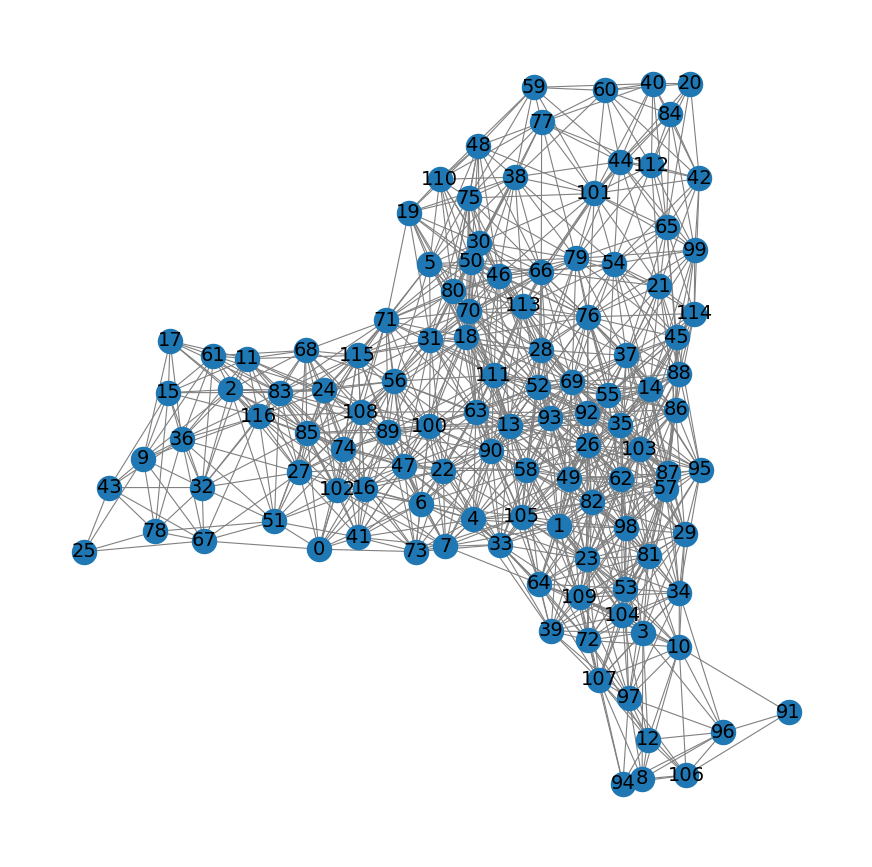

In [4]:
# create the dataset object
dataset = MesonetGraphDataset('./')
# define the training set
train_dataset = dataset[:(len(dataset) // 10)*7]
# define the testing and validation sets
val_dataset = dataset[(len(dataset) // 10)*7:(len(dataset) // 10)*8]
test_dataset = dataset[(len(dataset) // 10)*8:]

#shuffle them
train_dataset = train_dataset.shuffle()
val_dataset = val_dataset.shuffle()
test_dataset = test_dataset.shuffle()

loaded = np.load('./data/nanless_station_times.npy')
loaded = np.transpose(loaded, [1, 0, 2])

intance = torch.tensor(loaded[0])
print(intance.size())

lat_min, lat_max = intance[:, 0].min(), intance[:, 0].max()
lon_min, lon_max = intance[:, 1].min(), intance[:, 1].max()

lat_range = lat_max - lat_min
lon_range = lon_max - lon_min

# create the network graph for visualization
G = to_networkx(test_dataset[0], to_undirected=True)
plt.figure(figsize=(11,11))
plt.axis('off')
# visualize the network graph
# if you wanted to make the node positions correspond to the real NYSM: https://stackoverflow.com/questions/11804730/networkx-add-node-with-specific-position
nx.draw_networkx(G,
                pos= {i: ((intance[i, 1] - lon_min) / lon_range, (intance[i, 0] - lat_min) / lat_range) for i in range(intance.size()[0])}, # nx.spring_layout(G, seed=1),
                with_labels=True,
                node_size=300,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
# size of datasets
print(len(train_dataset), len(test_dataset))

# Now, Let's perform an experiment

In [18]:
# build the model
model = GCN(27)
# print a basic summary
print(model)

GCN(
  (norm): BatchNorm(27)
  (gc0): GraphConv(-1, 32)
  (gc1): GraphConv(32, 64)
  (gc2): GraphConv(64, 32)
  (gc3): GraphConv(32, 27)
)


In [27]:
from copy import deepcopy as copy
# training loop
def train():
    # tell the model it is training
    model.train()
    
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output[data.idx], label[data.idx])
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
        
    return loss_all / len(train_dataset)

def evaluate(loader):
    model.eval()

    loss_all = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).detach().cpu()
            label = data.y.detach().cpu()
            loss_all += crit(pred[data.idx], label[data.idx])
    
    return (loss_all / len(loader))

# device to train on, 'cpu' for cpu training
device = torch.device('cuda')
# send the model to the device
model = model.to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss fn
crit = torch.nn.MSELoss()
# data loader for training
train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
# train the model
best_loss = evaluate(val_loader)
best_state = None
for epoch in range(250):
    train_loss = train()
    val_loss = evaluate(val_loader)
    # restoring best weights
    if best_loss > val_loss:
        best_loss = val_loss
        best_state = copy(model.state_dict())
    print(f'epoch: {epoch}, train loss: {train_loss} val loss: {val_loss}', end='\r')
model.load_state_dict(best_state)
print()

epoch: 249, train loss: 56.336031843714764 val loss: 85.24501800537115


In [ ]:
class Expand(torch.nn.Module):
    # expand the graph by duplicating each node
    def __init__(self, in_channels: int, out_channels: int,
                 bias: bool = False, has_self_connections=False, **kwargs):

        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.has_self_connections = has_self_connections

        self.lin0 = Linear(in_channels, out_channels, bias=bias,
                          weight_initializer='glorot')
        self.lin1 = Linear(in_channels, out_channels, bias=bias,
                  weight_initializer='glorot')

        self.reset_parameters()


    def reset_parameters(self):
        # TODO reset custom parameters
        super().reset_parameters()
        self.lin0.reset_parameters()
        self.lin1.reset_parameters()


    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:

        x = torch.cat((self.lin0(x), self.lin1(x)))
        # at this point we have 2x the nodes but the new nodes are all disconnected
        
        if isinstance(edge_index, Tensor):
            # edge_index, 2 * edge_index
            # (edge_index[0, :], edge_index[1, :]), 
            # torch.cat((2 * edge_index[0, :], edge_index[1, :])), torch.cat((edge_index[0, :], 2 * edge_index[1, :]))
            # torch.cat((2 * edge_index[0, :], edge_index[0, :])), torch.cat((edge_index[1, :], 2 * edge_index[1, :]))
            if self.has_self_connections:
                edge_index = torch.cat((edge_index, 2 * edge_index, torch.cat((2 * edge_index[0, :], edge_index[1, :])), torch.cat((edge_index[0, :], 2 * edge_index[1, :]))), axis=-1)
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight))
            else:
                edge_index = torch.cat((edge_index, 2 * edge_index, torch.cat((2 * edge_index[0, :], edge_index[1, :])), torch.cat((edge_index[0, :], 2 * edge_index[1, :])), 
                                        torch.cat((2 * edge_index[0, :], edge_index[0, :])), torch.cat((edge_index[1, :], 2 * edge_index[1, :]))), axis=-1)
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight, torch.ones_like(edge_weight), torch.ones_like(edge_weight)))

        elif isinstance(edge_index, SparseTensor):
            if self.has_self_connections:
                edge_index = torch.cat((torch.cat((edge_index, edge_index), -1), torch.cat((edge_index, edge_index), -1)))
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight))
            else:
                edge_index = torch.cat((torch.cat((edge_index, edge_index + torch.eye(edge_index.size()[-1]).to_sparse()), -1), torch.cat((edge_index + torch.eye(edge_index.size()[-1]).to_sparse(), edge_index), -1)))
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight, torch.ones_like(edge_weight), torch.ones_like(edge_weight)))
        
        # now the new nodes are connected to the old nodes and the old nodes' connections
        
        return x, edge_index

    
class ExpandReweight(torch_geometric.nn.conv.MessagePassing):
    # expand the graph by duplicating each node
    def __init__(self, in_channels: int, out_channels: int,
                 bias: bool = False, has_self_connections=False, **kwargs):

        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.has_self_connections = has_self_connections

        self.lin0 = Linear(in_channels, out_channels, bias=bias,
                          weight_initializer='glorot')
        self.lin1 = Linear(in_channels, out_channels, bias=bias,
                  weight_initializer='glorot')
        
        self.A = Linear(out_channels, out_channels, bias=bias,
                          weight_initializer='glorot')
        self.B = Linear(out_channels, out_channels, bias=bias,
                  weight_initializer='glorot')

        self.reset_parameters()


    def reset_parameters(self):
        # TODO reset custom parameters
        super().reset_parameters()
        self.lin0.reset_parameters()
        self.lin1.reset_parameters()
        self.A.reset_parameters()
        self.B.reset_parameters()
        
    def edge_update(self, view_A, view_B, i, j):
        return 

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        edge_weight = 
        # TODO: activate these transformations?
        x = torch.cat((self.lin0(x), self.lin1(x)))
        # at this point we have 2x the nodes but the new nodes are all disconnected
        
        if isinstance(edge_index, Tensor):
            # edge_index, 2 * edge_index
            # (edge_index[0, :], edge_index[1, :]), 
            # torch.cat((2 * edge_index[0, :], edge_index[1, :])), torch.cat((edge_index[0, :], 2 * edge_index[1, :]))
            # torch.cat((2 * edge_index[0, :], edge_index[0, :])), torch.cat((edge_index[1, :], 2 * edge_index[1, :]))
            if self.has_self_connections:
                edge_index = torch.cat((edge_index, 2 * edge_index, torch.cat((2 * edge_index[0, :], edge_index[1, :])), torch.cat((edge_index[0, :], 2 * edge_index[1, :]))), axis=-1)
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight))
            else:
                edge_index = torch.cat((edge_index, 2 * edge_index, torch.cat((2 * edge_index[0, :], edge_index[1, :])), torch.cat((edge_index[0, :], 2 * edge_index[1, :])), 
                                        torch.cat((2 * edge_index[0, :], edge_index[0, :])), torch.cat((edge_index[1, :], 2 * edge_index[1, :]))), axis=-1)
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight, torch.ones_like(edge_weight), torch.ones_like(edge_weight)))

        elif isinstance(edge_index, SparseTensor):
            if self.has_self_connections:
                edge_index = torch.cat((torch.cat((edge_index, edge_index), -1), torch.cat((edge_index, edge_index), -1)))
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight))
            else:
                edge_index = torch.cat((torch.cat((edge_index, edge_index + torch.eye(edge_index.size()[-1]).to_sparse()), -1), torch.cat((edge_index + torch.eye(edge_index.size()[-1]).to_sparse(), edge_index), -1)))
                edge_weight = torch.cat((edge_weight, edge_weight, edge_weight, edge_weight, torch.ones_like(edge_weight), torch.ones_like(edge_weight)))
        
        # now the new nodes are connected to the old nodes and the old nodes' connections
        
        # similarity scores between embeddings are to be multiplied with the edge, and then the sigmoid is to be applied.  The edge is dropped if its weight is sufficiently low.
        # we could compute the sigmoid of the quantity A B ^T [i, j], multiply it by the edge weight and then drop the low weight edges
        #   this is more general, but I am not sure what it means
        view_A, view_B = self.A(x), self.B(x)
        # TODO: fix for SparseTensor adjacency matrix
        # TODO: add temperature hyperparameter
        edge_weight *= torch.nn.CosineSimilarity(dim=1, eps=1e-08)(view_A[edge_index[0]], view_B[:, edge_index[1]].transpose(-1, -2)).sigmoid()
        # TODO: make this threshold parameter a hyperparameter
        remaining_edges = torch.where(edge_weight > .01)
        
        edge_weight = edge_weight[remaining_edges]
        # TODO: conditional for abandoning orphans, perhaps some can stay (for some reason?)
        edge_index = edge_index.transpose(-1, -2)[remaining_edges].transpose(-1, -2)
        
        # it is clear we can say x = x[edge_index.unique()]
        
        return x, edge_index, edge_weight

In [23]:
A = torch.tensor([[1., 2.], [3., 4.]])
e_i = torch.tensor([[0, 1, 1], [0, 1, 0]])
weights = torch.tensor([1., 1., 1.])
scores = torch.nn.CosineSimilarity(dim=1, eps=1e-08)(A[e_i[0]], A[:,e_i[1]].transpose(0, 1))
scores *= 

In [25]:
scores.sigmoid()

tensor([0.7291, 0.7279, 0.7209])

In [34]:
e_i.transpose(0, 1)[torch.where(scores.sigmoid() > .721)].transpose(0, 1)

tensor([[0, 1],
        [0, 1]])

In [35]:
edge_index = e_i
mask = torch.zeros(num_nodes, dtype=torch.uint8)
mask[edge_index.unique()] = 1

assoc = torch.full((num_nodes, ), -1, dtype=torch.long))
assoc[mask] = torch.arange(mask.sum())

new_edge_index = assoc[edge_index]
# new_x = x[mask]
# new_pos = pos[mask]

tensor([0, 1])

In [26]:
test_loader = DataLoader(test_dataset, batch_size=128)
print('testing mse:', float(evaluate(test_loader)))
print('val mse:', float(evaluate(val_loader)))
print('train mse:', float(evaluate(train_loader)))

testing mse: 76.35717010498047
val mse: 79.54469299316406
train mse: 46.237648010253906
